# Transition-based arc-eager unlabeled dependency parser for Ukrainian

## Read the data

Useful links:
* [UD corpus for Ukrainian](https://github.com/UniversalDependencies/UD_Ukrainian-IU/)
* [Easy-to-use library for parsing UD](https://github.com/EmilStenstrom/conllu)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install wget conllu

In [3]:
from enum import Enum
from os.path import join, isfile, isdir
from os import mkdir
from random import Random
from typing import List, Dict
from collections import OrderedDict

In [4]:
import wget
from conllu import parse, TokenList

_url_prefix = "https://github.com/UniversalDependencies/UD_Ukrainian-IU/blob/master/"
DEV_FILENAME = "uk_iu-ud-dev.conllu"
TEST_FILENAME = "uk_iu-ud-test.conllu"
TRAIN_FILENAME = "uk_iu-ud-train.conllu"

_PATH = "data/"

_rnd = Random(1974)


def load_trees(filename: str) -> List[TokenList]:
    if not isdir(_PATH):
        mkdir(_PATH)

    full_name = join(_PATH, filename)
    if not isfile(full_name):
        wget.download(_url_prefix + filename + '?raw=true', full_name)

    with open(full_name, "r", encoding='utf-8') as f:
        data = f.read()
    result = parse(data)
    return result

In [5]:
trees = load_trees(DEV_FILENAME)
tokens = sum(len(tree) for tree in trees)
print(f"Dev set contains {tokens} tokens in {len(trees)} sentences")
trees = load_trees(TEST_FILENAME)
tokens = sum(len(tree) for tree in trees)
print(f"Test set contains {tokens} tokens in {len(trees)} sentences")
trees = load_trees(TRAIN_FILENAME)
tokens = sum(len(tree) for tree in trees)
print(f"Train set contains {tokens} tokens in {len(trees)} sentences")
tree = trees[0]
print(tree[0])
for node in tree:
    head = node["head"]
    print("{} <-- {}".format(node["form"],
                         tree[head - 1]["form"]
                             if head > 0 else "root"))


Dev set contains 11899 tokens in 647 sentences
Test set contains 16293 tokens in 864 sentences
Train set contains 88252 tokens in 5290 sentences
OrderedDict([('id', 1), ('form', 'У'), ('lemma', 'у'), ('upostag', 'ADP'), ('xpostag', 'Spsl'), ('feats', OrderedDict([('Case', 'Loc')])), ('head', 2), ('deprel', 'case'), ('deps', [('case', 2)]), ('misc', OrderedDict([('Id', '0003'), ('LTranslit', 'u'), ('Translit', 'U')]))])
У <-- домі
домі <-- була
римського <-- патриція
патриція <-- домі
Руфіна <-- патриція
була <-- root
прегарна <-- фреска
фреска <-- була
, <-- зображення
зображення <-- фреска
Венери <-- зображення
та <-- Адоніса
Адоніса <-- Венери
. <-- була


In [6]:
tree = trees[0]
print(tree[0])

OrderedDict([('id', 1), ('form', 'У'), ('lemma', 'у'), ('upostag', 'ADP'), ('xpostag', 'Spsl'), ('feats', OrderedDict([('Case', 'Loc')])), ('head', 2), ('deprel', 'case'), ('deps', [('case', 2)]), ('misc', OrderedDict([('Id', '0003'), ('LTranslit', 'u'), ('Translit', 'U')]))])


In [7]:
for node in tree:
    head = node["head"]
    print("{} <-- {}".format(node["form"],
                             tree[head - 1]["form"]
                             if head > 0 else "root"))

У <-- домі
домі <-- була
римського <-- патриція
патриція <-- домі
Руфіна <-- патриція
була <-- root
прегарна <-- фреска
фреска <-- була
, <-- зображення
зображення <-- фреска
Венери <-- зображення
та <-- Адоніса
Адоніса <-- Венери
. <-- була


## Design actions and the oracle

We will be using a static oracle that reproduces a single valid order of actions.

In [8]:
class Actions(str, Enum):
    SHIFT = "shift"
    REDUCE = "reduce"
    RIGHT = "right"
    LEFT = "left"

In [9]:
def oracle(stack, top_queue, relations):
    """
    Make a decision on the right action to do.
    """
    top_stack = stack[-1]
    # check if both stack and queue are non-empty
    if top_stack and not top_queue:
        return Actions.REDUCE
    # check if there are any clear dependencies
    elif top_queue["head"] == top_stack["id"]:
        return Actions.RIGHT
    elif top_stack["head"] == top_queue["id"]:
        return Actions.LEFT
    # check if we can reduce the top of the stack
    elif top_stack["id"] in [i[0] for i in relations] and \
         (top_queue["head"] < top_stack["id"] or \
          [s for s in stack if s["head"] == top_queue["id"]]):
        return Actions.REDUCE
    # default option
    else:
        return Actions.SHIFT

In [10]:
ROOT = OrderedDict([('id', 0), ('form', 'ROOT'), ('lemma', 'ROOT'), ('upostag', 'ROOT'),
                    ('xpostag', None), ('feats', None), ('head', None), ('deprel', None),
                    ('deps', None), ('misc', None)])

def trace_actions(tree, log=True):
    """
    Try out the oracle to verify it's returning the right actions.
    """
    stack, queue, relations = [ROOT], tree[:], []
    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        if log:
            print("Stack:", [i["form"]+"_"+str(i["id"]) for i in stack])
            print("Queue:", [i["form"]+"_"+str(i["id"]) for i in queue])
            print("Relations:", relations)
            print(action)
            print("========================")
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    if log:
        print("Gold relations:")
        print([(node["id"], node["head"]) for node in tree])
        print("Retrieved relations:")
        print(sorted(relations))

trace_actions(tree)

Stack: ['ROOT_0']
Queue: ['У_1', 'домі_2', 'римського_3', 'патриція_4', 'Руфіна_5', 'була_6', 'прегарна_7', 'фреска_8', ',_9', 'зображення_10', 'Венери_11', 'та_12', 'Адоніса_13', '._14']
Relations: []
Actions.SHIFT
Stack: ['ROOT_0', 'У_1']
Queue: ['домі_2', 'римського_3', 'патриція_4', 'Руфіна_5', 'була_6', 'прегарна_7', 'фреска_8', ',_9', 'зображення_10', 'Венери_11', 'та_12', 'Адоніса_13', '._14']
Relations: []
Actions.LEFT
Stack: ['ROOT_0']
Queue: ['домі_2', 'римського_3', 'патриція_4', 'Руфіна_5', 'була_6', 'прегарна_7', 'фреска_8', ',_9', 'зображення_10', 'Венери_11', 'та_12', 'Адоніса_13', '._14']
Relations: [(1, 2)]
Actions.SHIFT
Stack: ['ROOT_0', 'домі_2']
Queue: ['римського_3', 'патриція_4', 'Руфіна_5', 'була_6', 'прегарна_7', 'фреска_8', ',_9', 'зображення_10', 'Венери_11', 'та_12', 'Адоніса_13', '._14']
Relations: [(1, 2)]
Actions.SHIFT
Stack: ['ROOT_0', 'домі_2', 'римського_3']
Queue: ['патриція_4', 'Руфіна_5', 'була_6', 'прегарна_7', 'фреска_8', ',_9', 'зображення_10', 'В

## Feature extraction

Reference: [Dependency Parsing by Kübler, McDonald, and Nivre](https://books.google.com.ua/books?id=k3iiup7HB9UC&pg=PA21&hl=uk&source=gbs_toc_r&cad=4#v=onepage&q&f=false)

In [11]:
def extract_features(stack, queue):
    features = dict()
    if len(stack) > 0:
        stack_top = stack[-1]
        features["s0-word"] = stack_top["form"]
        features["s0-lemma"] = stack_top["lemma"]
        features["s0-tag"] = stack_top["upostag"]
        if stack_top["feats"]:
            for k, v in stack_top["feats"].items():
                features["s0-" + k] = v
    if len(stack) > 1:
        features["s1-tag"] = stack_top["upostag"]
    if queue:
        queue_top = queue[0]
        features["q0-word"] = queue_top["form"]
        features["q0-lemma"] = queue_top["lemma"]
        features["q0-tag"] = queue_top["upostag"]
        if queue_top["feats"]:
            for k, v in queue_top["feats"].items():
                features["q0-" + k] = v
    if len(queue) > 1:
        queue_next = queue[1]
        features["q1-word"] = queue_next["form"]
        features["q1-tag"] = queue_next["upostag"]
    if len(queue) > 2:
        features["q2-tag"] = queue[2]["upostag"]
    if len(queue) > 3:
        features["q3-tag"] = queue[3]["upostag"]
    if stack and queue:
        features["distance"] = queue[0]["id"] - stack[-1]["id"]
    return features

## Prepare train and test data

In [12]:
def get_data(tree):
    features, labels = [], []
    stack, queue, relations = [ROOT], tree[:], []

    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        features.append(extract_features(stack, queue))
        labels.append(action.value)
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    return features, labels

In [13]:
features, labels = get_data(tree)
print("Number of words:", len(tree))
print("Number of actions:", len(labels))
print("List of actions taken:", labels)
print("Features:")
for word in features:
    print(word)

Number of words: 14
Number of actions: 29
List of actions taken: ['shift', 'left', 'shift', 'shift', 'left', 'right', 'right', 'reduce', 'reduce', 'left', 'right', 'shift', 'left', 'right', 'shift', 'left', 'right', 'right', 'shift', 'left', 'right', 'reduce', 'reduce', 'reduce', 'reduce', 'right', 'reduce', 'reduce', 'reduce']
Features:
{'s0-word': 'ROOT', 's0-lemma': 'ROOT', 's0-tag': 'ROOT', 'q0-word': 'У', 'q0-lemma': 'у', 'q0-tag': 'ADP', 'q0-Case': 'Loc', 'q1-word': 'домі', 'q1-tag': 'NOUN', 'q2-tag': 'ADJ', 'q3-tag': 'NOUN', 'distance': 1}
{'s0-word': 'У', 's0-lemma': 'у', 's0-tag': 'ADP', 's0-Case': 'Loc', 's1-tag': 'ADP', 'q0-word': 'домі', 'q0-lemma': 'дім', 'q0-tag': 'NOUN', 'q0-Animacy': 'Inan', 'q0-Case': 'Loc', 'q0-Gender': 'Masc', 'q0-Number': 'Sing', 'q1-word': 'римського', 'q1-tag': 'ADJ', 'q2-tag': 'NOUN', 'q3-tag': 'PROPN', 'distance': 1}
{'s0-word': 'ROOT', 's0-lemma': 'ROOT', 's0-tag': 'ROOT', 'q0-word': 'домі', 'q0-lemma': 'дім', 'q0-tag': 'NOUN', 'q0-Animacy': 'I

In [14]:
train_features, train_labels = [], []
for tree in trees:
    tree_features, tree_labels = get_data([t for t in tree if type(t["id"])==int])
    train_features += tree_features
    train_labels += tree_labels

print(len(train_features), len(train_labels))

181376 181376


In [15]:
# Dev data

dev_trees = load_trees(DEV_FILENAME)

dev_features, dev_labels = [], []
for tree in dev_trees:
    tree_features, tree_labels = get_data([t for t in tree if type(t["id"])==int])
    dev_features += tree_features
    dev_labels += tree_labels

print(len(dev_features), len(dev_labels))

24423 24423


In [16]:
# Test data

test_trees = load_trees(TEST_FILENAME)

test_features, test_labels = [], []
for tree in test_trees:
    tree_features, tree_labels = get_data([t for t in tree if type(t["id"])==int])
    test_features += tree_features
    test_labels += tree_labels

print(len(test_features), len(test_labels))

33406 33406


## Train a classifier

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [18]:
vectorizer = DictVectorizer()
vec = vectorizer.fit(train_features)

print("\nTotal number of features: ", len(vec.get_feature_names()))


Total number of features:  107993


In [19]:
train_features_vectorized = vec.transform(train_features)
dev_features_vectorized = vec.transform(dev_features)
test_features_vectorized = vec.transform(test_features)

print(train_features_vectorized.shape)
print(dev_features_vectorized.shape)
print(test_features_vectorized.shape)

(181376, 107993)
(24423, 107993)
(33406, 107993)


In [20]:
lrc = LogisticRegression(random_state=42, n_jobs=4, 
                         solver="sag", multi_class="multinomial", max_iter=2000, verbose=1)
lrc.fit(train_features_vectorized, train_labels)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 1997 epochs took 403 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  6.7min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='multinomial',
          n_jobs=4, penalty='l2', random_state=42, solver='sag',
          tol=0.0001, verbose=1, warm_start=False)

In [21]:
predicted = lrc.predict(test_features_vectorized)
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

        left       0.85      0.87      0.86      8222
      reduce       0.81      0.72      0.76      8913
       right       0.74      0.80      0.77      7897
       shift       0.88      0.89      0.88      8374

   micro avg       0.82      0.82      0.82     33406
   macro avg       0.82      0.82      0.82     33406
weighted avg       0.82      0.82      0.82     33406



## Calculate the unlabeled attachment score
UAS - the percentage of words in an input that are assigned the correct head.

In [22]:
def dep_parse(sentence, oracle, vectorizer, log=True):
    stack, queue, relations = [ROOT], sentence[:], []
    while queue or stack:
        if stack and not queue:
            stack.pop()
        else:
            features = extract_features(stack, queue)
            action = oracle.predict(vectorizer.transform([features]))[0]
            if log:
                print("Stack:", [i["form"]+"_"+str(i["id"]) for i in stack])
                print("Queue:", [i["form"]+"_"+str(i["id"]) for i in queue])
                print("Relations:", relations)
                print(action)
                print("========================")
            # actual parsing
            if action == Actions.SHIFT:
                stack.append(queue.pop(0))
            elif action == Actions.REDUCE:
                stack.pop()
            elif action == Actions.LEFT:
                relations.append((stack[-1]["id"], queue[0]["id"]))
                stack.pop()
            elif action == Actions.RIGHT:
                relations.append((queue[0]["id"], stack[-1]["id"]))
                stack.append(queue.pop(0))
            else:
                print(f"Unknown action '{action}'.")
    return sorted(relations)

In [23]:
total, tp = 0, 0
for tree in test_trees:
    tree = [t for t in tree if type(t["id"])==int]
    golden = [(node["id"], node["head"]) for node in tree]
    predicted = dep_parse(tree, lrc, vec, log=False)
    total += len(tree)
    tp += len(set(golden).intersection(set(predicted)))

print("Total:", total)
print("Correctly defined:", tp)
print("UAS:", round(tp/total, 2))

Total: 16271
Correctly defined: 11520
UAS: 0.71


## Train a NN classifier

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7206757344642715689
]


In [25]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import numpy as np

In [26]:
labels_list = list(set(train_labels))
print(labels_list)
labels_dict = {name:i for i, name in enumerate(labels_list)}
print(labels_dict)

['right', 'reduce', 'left', 'shift']
{'right': 0, 'reduce': 1, 'left': 2, 'shift': 3}


In [27]:
def labels_to_ind(y: np.array)->np.array:
    return np.array([labels_dict[name] for name in y])

In [28]:
train_labels_idx = labels_to_ind(train_labels)
one_hot_train_labels = to_categorical(train_labels_idx)
dev_labels_idx = labels_to_ind(dev_labels)
one_hot_dev_labels = to_categorical(dev_labels_idx)
test_labels_idx = labels_to_ind(test_labels)
one_hot_test_labels = to_categorical(test_labels_idx)

In [33]:
early_stopping=EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('data/weights.best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [34]:
def construct_model():
    dim = train_features_vectorized.shape[1]
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', 
                           kernel_regularizer=regularizers.l1_l2(0.00005, 0.001), 
                           input_shape=(dim,)))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(0.00005, 0.001)))
    model.add(layers.Dense(len(labels_dict), activation='softmax'))
    return model

In [35]:
model = construct_model()
model.compile(optimizer=Adam(lr=0.002),
              #optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
history = model.fit(
            train_features_vectorized,
            one_hot_train_labels,
            epochs=100,
            batch_size=256,
            validation_data=(dev_features_vectorized, one_hot_dev_labels),
            callbacks=[early_stopping, reduce_lr, checkpoint]
          )

Train on 181376 samples, validate on 24423 samples
Epoch 1/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.7060 - acc: 0.8104
Epoch 00001: val_acc improved from -inf to 0.83319, saving model to data/weights.best.hdf5
181376/181376 [==============================] - 227s 1ms/sample - loss: 0.7060 - acc: 0.8103 - val_loss: 0.6443 - val_acc: 0.8332
Epoch 2/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.6221 - acc: 0.8427
Epoch 00002: val_acc improved from 0.83319 to 0.84175, saving model to data/weights.best.hdf5
181376/181376 [==============================] - 227s 1ms/sample - loss: 0.6221 - acc: 0.8426 - val_loss: 0.6187 - val_acc: 0.8417
Epoch 3/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.6070 - acc: 0.8463
Epoch 00003: val_acc improved from 0.84175 to 0.84596, saving model to data/weights.best.hdf5
181376/181376 [==============================] - 226s 1ms/sample - loss: 0.6070 - acc: 0.8463 - val_loss: 0.6123 -

181248/181376 [============================>.] - ETA: 0s - loss: 0.3857 - acc: 0.8754
Epoch 00028: val_acc did not improve from 0.86079
181376/181376 [==============================] - 234s 1ms/sample - loss: 0.3858 - acc: 0.8754 - val_loss: 0.4181 - val_acc: 0.8598
Epoch 29/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.3855 - acc: 0.8753
Epoch 00029: val_acc did not improve from 0.86079
181376/181376 [==============================] - 234s 1ms/sample - loss: 0.3855 - acc: 0.8754 - val_loss: 0.4181 - val_acc: 0.8607
Epoch 30/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.3853 - acc: 0.8761
Epoch 00030: val_acc did not improve from 0.86079
181376/181376 [==============================] - 232s 1ms/sample - loss: 0.3853 - acc: 0.8761 - val_loss: 0.4181 - val_acc: 0.8600
Epoch 31/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.3849 - acc: 0.8760
Epoch 00031: val_acc did not improve from 0.86079
181376/181376 [=========

Epoch 57/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.3713 - acc: 0.8786
Epoch 00057: val_acc did not improve from 0.86148
181376/181376 [==============================] - 223s 1ms/sample - loss: 0.3712 - acc: 0.8787 - val_loss: 0.4095 - val_acc: 0.8612
Epoch 58/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.3712 - acc: 0.8788
Epoch 00058: val_acc did not improve from 0.86148
181376/181376 [==============================] - 223s 1ms/sample - loss: 0.3712 - acc: 0.8788 - val_loss: 0.4095 - val_acc: 0.8612
Epoch 59/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.3712 - acc: 0.8788
Epoch 00059: val_acc did not improve from 0.86148
181376/181376 [==============================] - 223s 1ms/sample - loss: 0.3711 - acc: 0.8788 - val_loss: 0.4096 - val_acc: 0.8614
Epoch 60/100
181248/181376 [============================>.] - ETA: 0s - loss: 0.3710 - acc: 0.8789
Epoch 00060: val_acc did not improve from 0.86148
181376/1813

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

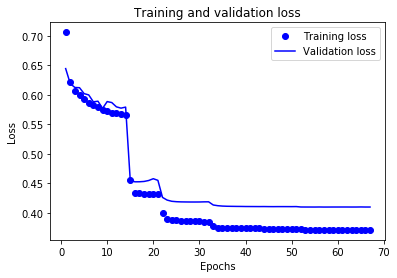

In [38]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

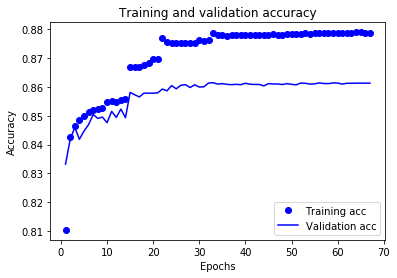

In [39]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
model = construct_model()
model.load_weights("data/weights.best.hdf5")
model.compile(optimizer=Adam(lr=0.002),
              #optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
results = model.evaluate(test_features_vectorized, one_hot_test_labels)
results

33406/33406 [==============================] - 47s 1ms/sample - loss: 0.4209 - acc: 0.8566


[0.42089903142497487, 0.85661256]

In [42]:
y_pred_one_hot = model.predict(test_features_vectorized)
y_pred = np.argmax(y_pred_one_hot, axis=1)
print(classification_report(test_labels_idx, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7897
           1       0.83      0.76      0.79      8913
           2       0.88      0.91      0.90      8222
           3       0.92      0.93      0.93      8374

   micro avg       0.86      0.86      0.86     33406
   macro avg       0.86      0.86      0.86     33406
weighted avg       0.86      0.86      0.86     33406



In [43]:
class OneHotWrapper:
    def __init__(self, oracle):
        self._oracle = oracle
    
    def predict(self, features):
        y_pred_one_hot = self._oracle.predict(features)
        y_pred = [labels_list[i] for i in np.argmax(y_pred_one_hot, axis=1)]
        #print(y_pred, y_pred_one_hot, features[0][:5])
        return y_pred

In [44]:
oracle = OneHotWrapper(model)

total, tp = 0, 0
for tree in test_trees:
    tree = [t for t in tree if type(t["id"])==int]
    golden = [(node["id"], node["head"]) for node in tree]
    predicted = dep_parse(tree, oracle, vec, log=False)
    total += len(tree)
    tp += len(set(golden).intersection(set(predicted)))

print("Total:", total)
print("Correctly defined:", tp)
print("UAS:", round(tp/total, 2))

Total: 16271
Correctly defined: 12337
UAS: 0.76
